In [1]:
import numpy as np
import matplotlib.pyplot as plt

from covapt_mt.covapt import covariance_model

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
pk_galaxy_file = "/home/joeadamo/Research/SPHEREx/spherex_emu/data/ps_eft_fid.npy"
n_galaxy = np.array([1e-4, 1e-4])

model = covariance_model(0.61, n_galaxy)
model.load_power_spectrum(pk_galaxy_file)

print(model.pk_galaxy.shape)

(2, 2, 2, 5, 25)


In [3]:
C_G = model.get_mt_gaussian_covariance()

0 0 0 0 0
0 0 0 1 0
0 0 1 1 0
0 1 0 0 50
0 1 0 1 50
0 1 1 1 50
1 1 0 0 100
1 1 0 1 100
1 1 1 1 100
0 0 0 0 0
0 0 0 1 0
0 0 1 1 0
0 1 0 0 50
0 1 0 1 50
0 1 1 1 50
1 1 0 0 100
1 1 0 1 100
1 1 1 1 100


In [10]:
def CorMat(cov):
    rms = np.sqrt(np.diag(cov))
    cor = np.copy(cov)
    for i in range(cov.shape[0]):
        for j in range(cov.shape[0]):
            cor[i,j] = cov[i,j]/(rms[i]*rms[j])
    return cor

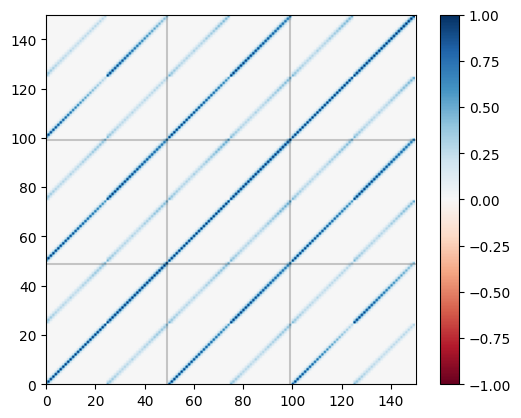

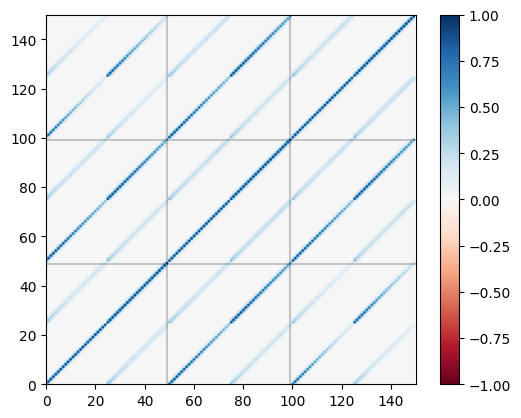

In [21]:
for z in range(model.num_zbins):

    try:
        L = np.linalg.cholesky(C_G[z])
    except:
        print("ERROR! Covariance matrix is not positive definite!")
        
    plt.figure()
    corr = CorMat(C_G[z])
    img = plt.imshow(corr, vmin=-1, vmax=1, cmap="RdBu")
    for i in range(model.num_spectra):
        plt.axvline(i*model.num_kbins*2 - 1, c="black", alpha=0.2)
        plt.axhline(i*model.num_kbins*2 - 1, c="black", alpha=0.2)
    plt.colorbar()
    plt.xlim(0, corr.shape[1])
    plt.ylim(0, corr.shape[1])

In [5]:
import itertools

for A, B in itertools.product(range(2), repeat=2):
    if B < A: continue
    for C, D in itertools.product(range(2), repeat=2):
        if D < C: continue
        print(A, B, C, D)

for A in range(3):
    for B in range(3):
        print(A, B)

0 0 0 0
0 0 0 1
0 0 1 1
0 1 0 0
0 1 0 1
0 1 1 1
1 1 0 0
1 1 0 1
1 1 1 1
0 0
0 1
0 2
1 0
1 1
1 2
2 0
2 1
2 2


In [6]:
pk_galaxy_raw = np.load(pk_galaxy_file)

num_zbins = pk_galaxy_raw.shape[0]
num_spectra = pk_galaxy_raw.shape[1]
num_tracers = 2
num_kbins = 25

#assert len(k) == pk_galaxy_raw.shape[3], "ERROR: Mismatched kbin lengths!"
print(pk_galaxy_raw.shape)
# reformat into form Elisabeth's code expects
# TODO: simplify this
pk_galaxy = np.zeros((num_zbins, num_tracers, num_tracers, 5, num_kbins))
for z in range(num_zbins):
    idx = 0
    for i, j in itertools.product(range(num_tracers), repeat=2):
        if i > j: continue
        pk_galaxy[z, i, j, 0, :] = pk_galaxy_raw[z, idx, 0, :]
        pk_galaxy[z, j, i, 0, :] = pk_galaxy_raw[z, idx, 0, :]
        pk_galaxy[z, i, j, 2, :] = pk_galaxy_raw[z, idx, 1, :]
        pk_galaxy[z, j, i, 2, :] = pk_galaxy_raw[z, idx, 1, :]
        pk_galaxy[z, i, j, 4, :] = pk_galaxy_raw[z, idx, 2, :]
        pk_galaxy[z, j, i, 4, :] = pk_galaxy_raw[z, idx, 2, :]
        idx +=1
    # L_idx = np.tril_indices(num_tracers)
    # print(num_tracers)
    # print(L_idx, pk_galaxy[z,L_idx,0,:].shape, pk_galaxy_raw[z,:,0,:].shape)
    # pk_galaxy[z, L_idx, 0, :] = pk_galaxy_raw[z, :, 0, :]
    # pk_galaxy[z, L_idx, 2, :] = pk_galaxy_raw[z, :, 1, :]
    # pk_galaxy[z, L_idx, 4, :] = pk_galaxy_raw[z, :, 2, :]
    # pk_galaxy[z] = np.transpose(pk_galaxy[z], (1, 0, 2, 3)) - np.diagonal(pk_galaxy[z], axis1=1, axis2=2)


(2, 3, 3, 25)
